### Parallel IDFT Model on Gen Matrix Encoded Data

In [164]:
# (r + 1) | (q - 1)
# (r + 1) | n
# q is a prime number
# n = 2^t
# r < n

In [165]:
%reset -f
import gc
gc.collect()

0

In [166]:
global w0
global z0

w0 = 4
z0 = 3

n = 27
q = 7
num_samples = 1000

num_unseen_samples = 20

In [167]:
import numpy as np
import tensorflow as tf

np.random.seed(42)

In [168]:
def next_power_of_two(x):
    return 1 if x == 0 else 2**(x - 1).bit_length()

n_padded = next_power_of_two(n)

dataset = np.random.randint(0, q, size=(num_samples, n))

if n_padded > n:
    pad_width = n_padded - n
    dataset = np.pad(dataset, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

print("Original n:", n)
print("Padded n:", n_padded)
print("Generated dataset shape:", dataset.shape)

Original n: 27
Padded n: 32
Generated dataset shape: (1000, 32)


In [169]:
print(dataset)

[[6 3 4 ... 0 0 0]
 [1 5 4 ... 0 0 0]
 [0 6 1 ... 0 0 0]
 ...
 [4 1 1 ... 0 0 0]
 [6 1 2 ... 0 0 0]
 [1 5 4 ... 0 0 0]]


$$
\tilde{M}_{kj} = \left[ \left( \frac{w_0}{z_0} \right)^j \zeta^{kj} \right]_{k,j=0}^{n-1}
$$

In [170]:
def padded_generator_matrix(N, w0, z0):
    n = np.arange(N)
    k = n.reshape((N, 1))
    zeta = np.exp(-2j * np.pi / N)
    M_tilde = ((w0 / z0) ** n) * (zeta ** (k * n))
    return M_tilde

In [171]:
M_tilde = padded_generator_matrix(n_padded, w0, z0)
print(M_tilde.shape)

(32, 32)


In [172]:
encoded_dataset = np.array([np.dot(M_tilde, x) for x in dataset])
encoded_dataset[np.abs(encoded_dataset) < 1e-10] = 0
encoded_dataset = np.round(encoded_dataset, decimals=10)

In [173]:
print(encoded_dataset.shape)

(1000, 32)


In [174]:
print(dataset[0])
print(encoded_dataset[0])

[6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
[18563.60052945    +0.j         -3175.07412411+14542.65392496j
 -9480.13851167 -1549.89213738j  -850.18419129 -5788.51248279j
  2813.63372348 -2457.36436449j  3312.0476391   +337.88077825j
  1059.2907911  +3489.68169028j -2366.82367016  +909.74502726j
  -210.29906943  +357.85181443j -3878.07651347  +373.95548592j
   -49.25036994 -6370.32567308j  6901.71964373 -1088.5938127j
  2896.76301761 +7252.43377368j -6714.83312544 +4427.90575271j
 -5496.28870703 -5330.43278044j  2828.24226801 -6162.17891893j
  6446.94186958    -0.j          2828.24226801 +6162.17891893j
 -5496.28870703 +5330.43278044j -6714.83312544 -4427.90575271j
  2896.76301761 -7252.43377368j  6901.71964373 +1088.5938127j
   -49.25036994 +6370.32567308j -3878.07651347  -373.95548592j
  -210.29906943  -357.85181443j -2366.82367016  -909.74502726j
  1059.2907911  -3489.68169028j  3312.0476391   -337.88077825j
  2813.63372348 +2457.36436449j  -850.18419129 +5788.5

In [175]:
X_real = np.real(encoded_dataset).astype(np.float32)
X_imag = np.imag(encoded_dataset).astype(np.float32)

print("\nX_train_real :", X_real.shape)
print(X_real[0])
print("\nX_train_imag :", X_imag.shape)
print(X_imag[0])


X_train_real : (1000, 32)
[18563.6     -3175.0742  -9480.139    -850.1842   2813.6338   3312.0476
  1059.2908  -2366.8237   -210.29907 -3878.0764    -49.25037  6901.7197
  2896.763   -6714.833   -5496.2886   2828.2422   6446.942    2828.2422
 -5496.2886  -6714.833    2896.763    6901.7197    -49.25037 -3878.0764
  -210.29907 -2366.8237   1059.2908   3312.0476   2813.6338   -850.1842
 -9480.139   -3175.0742 ]

X_train_imag : (1000, 32)
[     0.       14542.654    -1549.8921   -5788.5127   -2457.3643
    337.88077   3489.6816     909.74506    357.8518     373.95547
  -6370.3257   -1088.5939    7252.4336    4427.906    -5330.4326
  -6162.1787      -0.        6162.1787    5330.4326   -4427.906
  -7252.4336    1088.5939    6370.3257    -373.95547   -357.8518
   -909.74506  -3489.6816    -337.88077   2457.3643    5788.5127
   1549.8921  -14542.654  ]


In [176]:
y = dataset.astype(np.float32)
y_normalized = y / (q - 1)  # Scale to [0, 1]

print(y_normalized[0])

labels = y_normalized

[1.         0.5        0.6666667  1.         0.33333334 0.6666667
 0.6666667  1.         0.16666667 0.33333334 1.         0.33333334
 0.33333334 0.6666667  0.5        0.33333334 0.8333333  0.6666667
 0.16666667 0.5        0.8333333  0.8333333  0.16666667 0.5
 0.6666667  0.         0.5        0.         0.         0.
 0.         0.        ]


In [177]:
from sklearn.model_selection import train_test_split

X_real_train, X_real_test, y_train, y_test = train_test_split(
    X_real, labels, test_size=0.2, random_state=42
)

X_imag_train, X_imag_test, _, _ = train_test_split(
    X_imag, labels, test_size=0.2, random_state=42
)

print("Training data shapes: X_real:", X_real_train.shape, "X_imag:", X_imag_train.shape, "y:", y_train.shape)
print("Testing data shapes: X_real:", X_real_test.shape, "X_imag:", X_imag_test.shape, "y:", y_test.shape)

Training data shapes: X_real: (800, 32) X_imag: (800, 32) y: (800, 32)
Testing data shapes: X_real: (200, 32) X_imag: (200, 32) y: (200, 32)


In [178]:
# Normalize real part
real_mean = np.mean(X_real_train, axis=0)
real_std = np.std(X_real_train, axis=0)
X_real_train = (X_real_train - real_mean) / (real_std + 1e-8)
X_real_test = (X_real_test - real_mean) / (real_std + 1e-8)

# Normalize imag part
imag_mean = np.mean(X_imag_train, axis=0)
imag_std = np.std(X_imag_train, axis=0)
X_imag_train = (X_imag_train - imag_mean) / (imag_std + 1e-8)
X_imag_test = (X_imag_test - imag_mean) / (imag_std + 1e-8)

IDFT - Structure Imposed Neural Network

In [179]:
class IDFT(tf.keras.layers.Layer):
    def __init__(self, n, kernel_initializer='he_normal', trainable=True, **kwargs):
        super(IDFT, self).__init__(**kwargs)
        self.n = n
        self.n1 = n // 2
        self.trainable = trainable
        self.kernel_initializer = kernel_initializer

        if n == 2:
            self.F_2 = self.add_weight(
                shape=(2, 2),
                initializer=tf.keras.initializers.Constant([[0.5, 0.5], [0.5, -0.5]]),
                trainable=self.trainable,
                name='F_2'
            )
        else:
            self.idft1 = IDFT(self.n1, trainable=self.trainable)
            self.idft2 = IDFT(self.n1, trainable=self.trainable)

            self.Dn = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.get(self.kernel_initializer),
                trainable=self.trainable,
                name='Dn'
            )

    def call(self, x):
        if self.n == 2:
            return tf.matmul(x, self.F_2)

        even = x[:, ::2]
        odd = x[:, 1::2]

        B1 = self.idft1(even)
        B2 = self.idft2(odd)

        Dn_scaled = tf.multiply(B2, self.Dn)

        sum_part = B1 + Dn_scaled
        diff_part = B1 - Dn_scaled

        out = tf.concat([sum_part, diff_part], axis=1) / tf.sqrt(tf.constant(2.0, dtype=tf.float32))

        return out

In [180]:
class FirstIDFTLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', trainable=True, **kwargs):
        super(FirstIDFTLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

        self.b1 = IDFT(self.n1, kernel_initializer=self.kernel_initializer, trainable=self.trainable)
        self.b2 = IDFT(self.n1, kernel_initializer=self.kernel_initializer, trainable=self.trainable)

        self.bias = self.add_weight(
            shape=(units,),
            initializer=tf.keras.initializers.get(self.bias_initializer),
            trainable=True,
            name='bias'
        )

    def call(self, x):
      q = tf.concat([x[:, ::2], x[:, 1::2]], axis=1)
      B1 = self.b1(q[:, :self.n1])
      B2 = self.b2(q[:, self.n1:])
      out = tf.concat([B1, B2], axis=1)

      return out + self.bias

In [181]:
class SecondIDFTLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', trainable=True, **kwargs):
        super(SecondIDFTLayer, self).__init__(**kwargs)
        self.n = units
        self.n1 = units // 2
        self.trainable = trainable
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer

        self.Dn = self.add_weight(
                shape=(self.n1,),
                initializer=tf.keras.initializers.get(self.kernel_initializer),
                trainable=self.trainable,
                name='Dn'
            )

        self.bias = self.add_weight(
            shape=(units,),
            initializer=tf.keras.initializers.get(self.bias_initializer),
            trainable=True,
            name='bias'
        )

    def call(self, x):
        x1 = x[:, :self.n1]
        x2 = x[:, self.n1:]

        Dn_scaled = tf.multiply(x2, self.Dn)

        sum_part = x1 + Dn_scaled
        diff_part = x1 - Dn_scaled

        out = tf.concat([sum_part, diff_part], axis=1) / tf.sqrt(tf.constant(2.0, dtype=tf.float32))

        return out + self.bias

In [182]:
class DiagonalLayer(tf.keras.layers.Layer):
    def __init__(self, units, kernel_initializer='he_normal', bias_initializer='zeros', use_bias=True, **kwargs):
        super(DiagonalLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 trainable=True)

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        out = tf.multiply(inputs, self.m)
        if self.use_bias:
            out += self.bias
        return out

In [183]:
class ScalingLayer(tf.keras.layers.Layer):
    def __init__(self, units, initial_scale=0.1, kernel_initializer='ones', bias_initializer='zeros', use_bias=True, **kwargs):
        super(ScalingLayer, self).__init__(**kwargs)
        self.units = units
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.use_bias = use_bias
        self.initial_scale = initial_scale

    def build(self, input_shape):
        n = self.units

        self.m = self.add_weight(name="kernel_m_1",
                                 shape=(n,),
                                 initializer=tf.keras.initializers.get(self.kernel_initializer),
                                 regularizer=tf.keras.regularizers.l2(1e-4),
                                 trainable=True)

        self.log_scale = self.add_weight(
                                  shape=(),
                                  initializer=tf.keras.initializers.Constant(self.initial_scale),
                                  trainable=True,
                                  name="log_scale",
                                  )

        if self.use_bias:
            self.bias = self.add_weight(name="bias",
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.get(self.bias_initializer),
                                        trainable=True)

    def call(self, inputs):
        inputs1 = inputs[:, :int(inputs.shape[1] / 2)]
        inputs2 = inputs[:, int(inputs.shape[1] / 2):]

        out = tf.math.sqrt(inputs1**2 + inputs2**2)

        dim = tf.shape(out)[1]
        D_hat_n = tf.exp(self.log_scale * tf.cast(tf.range(dim), tf.float32))

        out2 = out * D_hat_n * self.m

        if self.use_bias:
            out2 += self.bias

        return out2

Model

In [184]:
def custom_accuracy(y_true, y_pred):
    y_true_int = tf.cast(y_true*(q-1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred*(q-1)), tf.int32)
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32)
    return tf.reduce_mean(correct)

def custom_accuracy_without_padding(y_true, y_pred):
    y_true_int = tf.cast(y_true * (q - 1), tf.int32)
    y_pred_int = tf.cast(tf.round(y_pred * (q - 1)), tf.int32)
    mask = tf.concat(
        [tf.ones((tf.shape(y_true)[0], n), dtype=tf.float32),
         tf.zeros((tf.shape(y_true)[0], n_padded - n), dtype=tf.float32)],
        axis=1
    )
    correct = tf.cast(tf.equal(y_true_int, y_pred_int), tf.float32) * mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    # weights = 1.0 / (1.0 + tf.abs(y_true))
    # loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    loss = tf.reduce_mean(tf.square(tf.cast(y_true - y_pred, tf.float32)))
    return loss

In [185]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

global initial_log_scale
initial_log_scale = np.log(z0 / w0)

def structured_NN(input_dim, output_dim):
    real_input = Input(shape=(input_dim,), name="real_input")
    imag_input = Input(shape=(input_dim,), name="imag_input")

    real_x = FirstIDFTLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="real_layer1")(real_input)
    # real_x = LeakyReLU(negative_slope=0.1)(real_x)
    # real_x = DiagonalLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="real_support_layer_1")(real_x)
    # real_x = LeakyReLU(negative_slope=0.1)(real_x)
    real_x = SecondIDFTLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="real_layer2")(real_x)
    real_x = LeakyReLU(negative_slope=0.1)(real_x)

    imag_x = FirstIDFTLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="imag_layer1")(imag_input)
    # imag_x = LeakyReLU(negative_slope=0.1)(imag_x)
    # imag_x = DiagonalLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="imag_support_layer_1")(imag_x)
    # imag_x = LeakyReLU(negative_slope=0.1)(imag_x)
    imag_x = SecondIDFTLayer(units=input_dim, kernel_initializer='he_normal', bias_initializer='zeros', name="imag_layer2")(imag_x)
    imag_x = LeakyReLU(negative_slope=0.1)(imag_x)

    merged = Concatenate(name="merge_real_imag")([real_x, imag_x])

    output = ScalingLayer(units=output_dim, initial_scale=initial_log_scale, kernel_initializer='ones', bias_initializer='zeros', name="scaling_layer")(merged)
    output = LeakyReLU(negative_slope=0.1)(output)
    output = DiagonalLayer(units=output_dim, trainable=False, kernel_initializer='ones', bias_initializer='zeros', name="output_layer")(output)
    output = Activation('linear')(output)

    model = Model(inputs=[real_input, imag_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=custom_mse, metrics=[custom_mse, custom_accuracy_without_padding])

    return model

input_dim = X_real_train.shape[1]
output_dim = y_train.shape[1]
model = structured_NN(input_dim, output_dim)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ real_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imag_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real_layer1         │ (None, 32)        │        144 │ real_input[0][0]  │
│ (FirstIDFTLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imag_layer1         │ (None, 32)        │        144 │ imag_input[0][0]  │
│ (FirstIDFTLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ real_layer2         │ (None, 32)        │         48 │ real_layer1[0][0] │
│ (SecondIDFTLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ imag_layer2         │ (None, 32)        │         48 │ imag_layer1[0][0] │
│ (SecondIDFTLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 32)        │          0 │ real_layer2[0][0] │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 32)        │          0 │ imag_layer2[0][0] │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_real_imag     │ (None, 64)        │          0 │ leaky_re_lu_15[0… │
│ (Concatenate)       │                   │            │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ scaling_layer       │ (None, 32)        │         65 │ merge_real_imag[… │
│ (ScalingLayer)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_17      │ (None, 32)        │          0 │ scaling_layer[0]… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 32)        │         64 │ leaky_re_lu_17[0… │
│ (DiagonalLayer)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32)        │          0 │ output_layer[0][… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 513 (2.00 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 64 (256.00 B)

In [186]:
# ------------- FLOP counts ---------------

# create concrete function for multiple inputs
input_shape = (1, input_dim)  # batch size 1

concrete_func = tf.function(model).get_concrete_function(
    [tf.TensorSpec(input_shape, tf.float32),  # real_input
     tf.TensorSpec(input_shape, tf.float32)]  # imag_input
)

from tensorflow.python.profiler import model_analyzer
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

profile_opts = ProfileOptionBuilder.float_operation()
flops = model_analyzer.profile(concrete_func.graph, options=profile_opts)

print('FLOPs:', flops.total_float_ops)

FLOPs: 1312


Train Model

In [187]:
# from google.colab import drive
# drive.mount('/content/drive')

In [188]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = f"/content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/DFT_model_{n}.keras"

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

adjust_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

history = model.fit(
    [X_real_train, X_imag_train],
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=([X_real_test, X_imag_test], y_test),
    callbacks=[adjust_lr, early_stopping, model_checkpoint]
)

Epoch 1/500
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_accuracy_without_padding: 0.1437 - custom_mse: 0.2791 - loss: 0.2823
Epoch 1: val_loss improved from inf to 0.25722, saving model to /content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/DFT_model_27.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - custom_accuracy_without_padding: 0.1435 - custom_mse: 0.2789 - loss: 0.2821 - val_custom_accuracy_without_padding: 0.1531 - val_custom_mse: 0.2531 - val_loss: 0.2572 - learning_rate: 0.0010
Epoch 2/500
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_accuracy_without_padding: 0.1470 - custom_mse: 0.2539 - loss: 0.2570
Epoch 2: val_loss improved from 0.25722 to 0.23294, saving model to /content/drive/MyDrive/10 Masters/Research/error-correcting-codes/ThisIsTheCleanest/weights/DFT_model_27.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - custom_accuracy_without_padding: 0.1465 - custom_mse: 0.2535 - loss: 0.2566 - val_custom_accuracy_without_padding

Evaluate

In [189]:
eval_results = model.evaluate([X_real_test, X_imag_test], y_test)
print(f"Test results - Loss: {eval_results[0]}, MSE: {eval_results[1]}, Accuracy: {eval_results[2]}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - custom_accuracy_without_padding: 0.4590 - custom_mse: 0.0538 - loss: 0.0546 
Test results - Loss: 0.05577055364847183, MSE: 0.05529003590345383, Accuracy: 0.4538690447807312


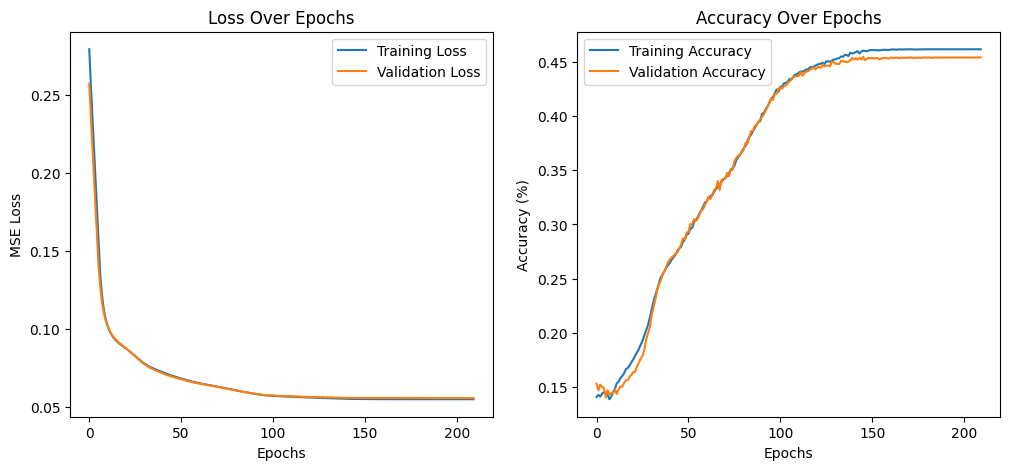

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy_without_padding'], label='Training Accuracy')
plt.plot(history.history['val_custom_accuracy_without_padding'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [191]:
y_pred = model.predict([X_real_test, X_imag_test])
y_test_rescaled = y_test * (q - 1)
y_pred_rescaled = y_pred * (q - 1)

print("Comparison of predictions and ground truth:")
for i in range(3):
    print(f"Sample {i+1}:")
    print(f"  Predicted:    {np.round(y_pred_rescaled[i]).astype(int)}")
    print(f"  Ground Truth: {np.round(y_test_rescaled[i]).astype(int)}")
    print("-" * 40)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
Comparison of predictions and ground truth:
Sample 1:
  Predicted:    [3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 1 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
  Ground Truth: [5 6 5 1 3 4 1 1 6 2 3 1 4 0 3 2 5 1 4 3 4 4 6 5 2 3 1 0 0 0 0 0]
----------------------------------------
Sample 2:
  Predicted:    [3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 2 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
  Ground Truth: [1 4 1 3 3 3 0 5 5 2 4 3 3 1 3 1 1 2 0 1 1 5 2 1 4 0 4 0 0 0 0 0]
----------------------------------------
Sample 3:
  Predicted:    [3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 2 5 1 4 5 0 4 3 2 3 4 4 0 0 0 0 0]
  Ground Truth: [2 6 0 2 2 1 3 4 2 6 4 1 0 5 2 3 5 1 4 6 0 4 3 2 3 4 4 0 0 0 0 0]
----------------------------------------


In [192]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")

R² Score: 0.3494


In [193]:
# ---------------------- Inference time on Test Set ----------------------------

import time

_ = model.predict([X_real_test, X_imag_test], verbose=0) # warm up

times = []
for _ in range(100):
    start = time.perf_counter()
    _ = model.predict([X_real_test, X_imag_test], verbose=0)
    end = time.perf_counter()
    times.append(end - start)

average_inference_time = np.mean(times)
print(f"Average batch inference time over 100 runs: {average_inference_time:.6f} seconds")

average_per_sample = average_inference_time / X_real_test.shape[0]
print(f"Average inference time per sample (from batch): {average_per_sample:.6f} seconds")


Average batch inference time over 100 runs: 0.122749 seconds
Average inference time per sample (from batch): 0.000614 seconds


Test on Unseen Samples

In [194]:
# --------------------- Predictions on unseen samples (for two-input model) -------------------------

np.random.seed(42)

unseen_data = np.random.randint(0, q, size=(num_unseen_samples, n))
padded_unseen_data = np.hstack((unseen_data, np.zeros((num_unseen_samples, n_padded - n))))

unseen_data_normalized = padded_unseen_data.astype(np.float32) / (q - 1)

unseen_encoded = np.array([np.dot(M_tilde, x) for x in padded_unseen_data])
unseen_encoded[np.abs(unseen_encoded) < 1e-10] = 0
unseen_encoded = np.round(unseen_encoded, decimals=10)

X_real_unseen = np.real(unseen_encoded).astype(np.float32)
X_imag_unseen = np.imag(unseen_encoded).astype(np.float32)

# Normalize
X_real_unseen = (X_real_unseen - real_mean) / (real_std + 1e-8)
X_imag_unseen = (X_imag_unseen - imag_mean) / (imag_std + 1e-8)

# Predict
y_pred_unseen = model.predict([X_real_unseen, X_imag_unseen], verbose=0)

mse_unseen = tf.reduce_mean(tf.square(unseen_data_normalized - y_pred_unseen)).numpy()
print(f"MSE on unseen data: {mse_unseen:.6f}")

accuracy_unseen = custom_accuracy_without_padding(unseen_data_normalized, y_pred_unseen)
print(f"Accuracy on unseen data: {accuracy_unseen:.6f}")

num_display_samples = 3
for i in range(num_display_samples):
    print(f"\nSample {i+1}:")
    true_labels = padded_unseen_data[i]
    pred_scaled = y_pred_unseen[i] * (q - 1)
    pred_rounded = tf.round(pred_scaled).numpy().astype(int)
    print(f"True     : {true_labels.astype(int)}")
    print(f"Predicted: {pred_rounded}")
    print("-" * 30)

MSE on unseen data: 0.056453
Accuracy on unseen data: 0.462963

Sample 1:
True     : [6 3 4 6 2 4 4 6 1 2 6 2 2 4 3 2 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
Predicted: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 5 4 1 3 5 5 1 3 4 0 3 0 0 0 0 0]
------------------------------

Sample 2:
True     : [1 5 4 3 0 0 2 2 6 1 3 3 6 5 5 6 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]
Predicted: [3 3 3 3 3 3 3 3 3 3 3 4 3 4 3 3 5 2 3 6 3 0 2 4 2 6 4 0 0 0 0 0]
------------------------------

Sample 3:
True     : [0 6 1 3 0 3 5 1 1 0 1 4 1 3 3 6 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]
Predicted: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 5 3 6 3 4 6 2 5 0 3 1 3 0 0 0 0 0]
------------------------------


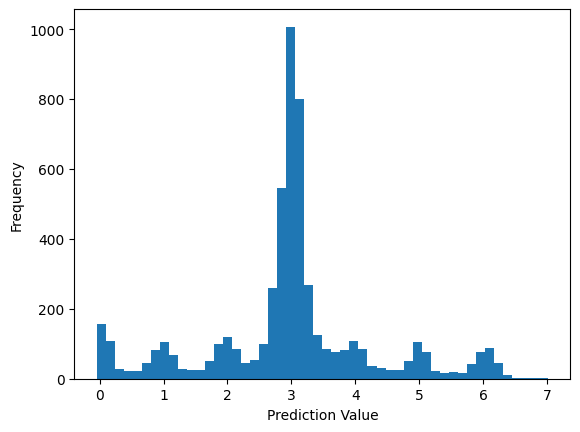

In [195]:
import matplotlib.pyplot as plt

# exclude zero pads
y_pred_first_n = y_pred[:, :n]
y_pred_first_n_rescaled = y_pred_first_n * (q - 1)

plt.hist(y_pred_first_n_rescaled.flatten(), bins=50)
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.show()